In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
import string
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

df = pd.read_csv('20newsgroups.csv', names=['Text','Label'], skiprows=1)

c:\Users\Axioo Pongo\anaconda3\envs\Stable\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df.head()

,Text,Label
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4


In [3]:
def simplify_text(email_text):
    def extract_body(email_text):
        parts = email_text.split('\n\n', 1)
        if len(parts) > 1:
            body = parts[1].strip()
            body = re.split(r'\n--', body, maxsplit=1)[0].strip()
            body = body.replace('\n', ' ')
            return body
        return email_text

    def remove_before_writes(text):
        if "writes:" in text:
            return text.rsplit("writes:",1)[1].strip()
        if "says:" in text:
            return text.rsplit("says:",1)[1].strip()
        if "wrote:" in text:
            return text.rsplit("wrote:",1)[1].strip()
        return text

    def remove_before_edu(text):
        if ".edu," in text:
            return text.split(".edu,")[1].strip()
        return text

    def clean_repeated_punctuation_and_spaces(text):
        cleaned_text = re.sub(r'([.,!?;:-])\1+', r'\1', text)
        # Replace multiple spaces with a single space
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
        # Strip leading and trailing spaces
        cleaned_text = cleaned_text.strip()
        return cleaned_text
    
    def remove_punctuation(text):
        return text.translate(str.maketrans('', '', string.punctuation.replace('.', '').replace(',', '').replace('?', '').replace('!', '')))

    def remove_websites_with_specific_domains(text):
        website_pattern = r'\S+(\.com|\.edu|\.org)\b|\bwww\.\S+?(\.com|\.edu|\.EDU|\.org)\b'
        # Menghapus URL dari teks
        return re.sub(website_pattern, '', text, flags=re.IGNORECASE).strip()
    
    def remove_punctuation_start(text):
        return re.sub(r'^[^\w\s]+', '', text)

    email_text = extract_body(email_text)
    email_text = remove_before_writes(email_text)
    email_text = remove_before_edu(email_text)
    email_text = remove_punctuation(email_text)
    email_text = clean_repeated_punctuation_and_spaces(email_text)
    email_text = remove_websites_with_specific_domains(email_text)
    email_text = remove_punctuation_start(email_text)
    return email_text

# Terapkan fungsi simplify_text ke kolom 'Text'
df['Text'] = df['Text'].apply(simplify_text)
df = df[df['Text'] != ''].drop(columns=['Label'])

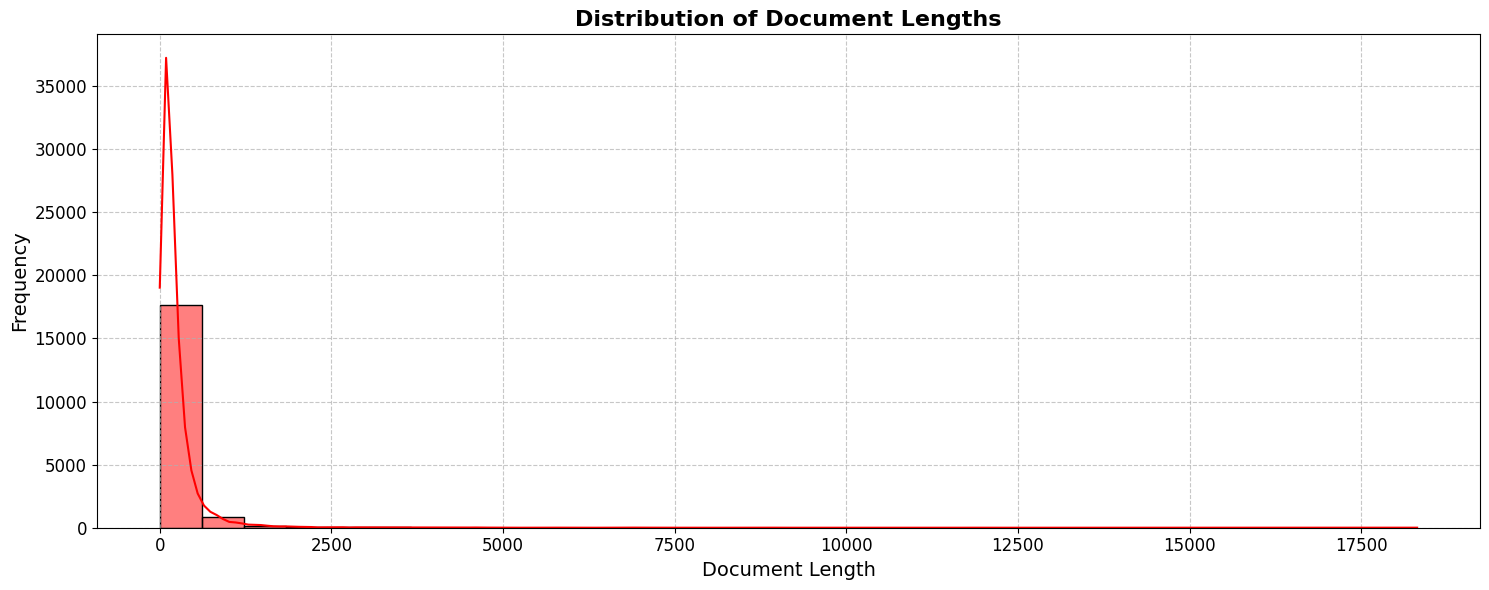

In [13]:
import nltk

doc_lengths = []

for bio in df['Text']:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)
plt.figure(figsize=(15, 6))
sns.histplot(doc_lengths, kde=True, color='red', bins=30)
plt.xlabel('Document Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Document Lengths', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [11]:
{
	'count': len(doc_lengths),
	'mean': np.mean(doc_lengths),
	'std': np.std(doc_lengths),
	'min': np.min(doc_lengths),
	'25%': np.percentile(doc_lengths, 25),
	'50%': np.median(doc_lengths),
	'75%': np.percentile(doc_lengths, 75),
	'max': np.max(doc_lengths)
}

{'count': 18807,
 'mean': np.float64(236.65220396660817),
 'std': np.float64(446.09442746205036),
 'min': np.int64(1),
 '25%': np.float64(75.0),
 '50%': np.float64(140.0),
 '75%': np.float64(256.0),
 'max': np.int64(18315)}

In [7]:
from datasets import Dataset
df = Dataset.from_pandas(df)

pretrained = 'microsoft/DialoGPT-small'
config = AutoConfig.from_pretrained(pretrained)
model = AutoModelForCausalLM.from_pretrained(pretrained, config=config)
tokenizer = AutoTokenizer.from_pretrained(pretrained)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    tokenized = tokenizer(
        examples["Text"], 
        padding="max_length", 
        truncation=True, 
        max_length=256,
        return_tensors="pt" )

    tokenized["labels"] = tokenized["input_ids"].clone()

    return tokenized

# Tokenize the dataset
tokenized_dataset = df.map(tokenize_function, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map: 100%|██████████| 18807/18807 [00:03<00:00, 4921.42 examples/s]


In [8]:
from transformers import GPT2Config
new_config = GPT2Config(
    # vocab_size=50257,
    # n_positions=1024,
    # n_embd=256,  # Ubah dimensi embedding menjadi 256
    # n_layer=8,
    temperature=10,
    do_sample=True
)
model = AutoModelForCausalLM.from_pretrained(pretrained, config=new_config)

In [9]:
split_datasets = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

train_val_split = split_datasets["train"].train_test_split(test_size=0.125, seed=42)  # 0.125 = 10% dari keseluruhan data

train_dataset = train_val_split["train"]
val_dataset = split_datasets["test"]
test_dataset = train_val_split["test"]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 13164
Validation dataset size: 3762
Test dataset size: 1881


In [10]:
from transformers import Trainer, TrainingArguments

# Define training arguments
args = TrainingArguments(
    output_dir='./results' + pretrained,
    num_train_epochs=10,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    learning_rate=2e-5,
    fp16=True,
    logging_dir='./logs' + pretrained,          # Directory to save logs
    logging_strategy="epoch",      # Log after each epoch
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

 10%|█         | 1097/10970 [05:51<53:40,  3.07it/s]

{'loss': 3.0263, 'grad_norm': 3.644819974899292, 'learning_rate': 1.8012762078395628e-05, 'epoch': 1.0}


                                                    
 10%|█         | 1097/10970 [06:42<53:40,  3.07it/s]c:\Users\Axioo Pongo\anaconda3\envs\Stable\lib\site-packages\transformers\modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'do_sample': True, 'temperature': 10}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'eval_loss': 2.5972092151641846, 'eval_runtime': 50.5623, 'eval_samples_per_second': 74.403, 'eval_steps_per_second': 74.403, 'epoch': 1.0}


 20%|██        | 2194/10970 [12:37<47:12,  3.10it/s]   

{'loss': 2.7087, 'grad_norm': 2.7174203395843506, 'learning_rate': 1.6012762078395626e-05, 'epoch': 2.0}


                                                    
 20%|██        | 2194/10970 [13:28<47:12,  3.10it/s]

{'eval_loss': 2.5361521244049072, 'eval_runtime': 50.2873, 'eval_samples_per_second': 74.81, 'eval_steps_per_second': 74.81, 'epoch': 2.0}


 30%|███       | 3291/10970 [19:22<41:02,  3.12it/s]   

{'loss': 2.6182, 'grad_norm': 2.8525896072387695, 'learning_rate': 1.4012762078395625e-05, 'epoch': 3.0}


                                                    
 30%|███       | 3291/10970 [20:12<41:02,  3.12it/s]

{'eval_loss': 2.499394416809082, 'eval_runtime': 49.8544, 'eval_samples_per_second': 75.46, 'eval_steps_per_second': 75.46, 'epoch': 3.0}


 40%|████      | 4388/10970 [26:08<35:25,  3.10it/s]   

{'loss': 2.5575, 'grad_norm': 2.9672751426696777, 'learning_rate': 1.2012762078395626e-05, 'epoch': 4.0}


                                                    
 40%|████      | 4388/10970 [26:59<35:25,  3.10it/s]

{'eval_loss': 2.4749598503112793, 'eval_runtime': 51.7266, 'eval_samples_per_second': 72.728, 'eval_steps_per_second': 72.728, 'epoch': 4.0}


 50%|█████     | 5485/10970 [33:02<30:30,  3.00it/s]   

{'loss': 2.5109, 'grad_norm': 2.596574306488037, 'learning_rate': 1.0012762078395626e-05, 'epoch': 5.0}


                                                    
 50%|█████     | 5485/10970 [36:03<30:30,  3.00it/s]

{'eval_loss': 2.4575250148773193, 'eval_runtime': 181.3206, 'eval_samples_per_second': 20.748, 'eval_steps_per_second': 20.748, 'epoch': 5.0}


 60%|██████    | 6582/10970 [42:06<24:00,  3.05it/s]   

{'loss': 2.4752, 'grad_norm': 2.233532428741455, 'learning_rate': 8.012762078395625e-06, 'epoch': 6.0}


                                                    
 60%|██████    | 6582/10970 [45:06<24:00,  3.05it/s]

{'eval_loss': 2.4442694187164307, 'eval_runtime': 180.0832, 'eval_samples_per_second': 20.89, 'eval_steps_per_second': 20.89, 'epoch': 6.0}


 70%|███████   | 7679/10970 [51:06<17:44,  3.09it/s]   

{'loss': 2.448, 'grad_norm': 2.3894553184509277, 'learning_rate': 6.0127620783956255e-06, 'epoch': 7.0}


                                                    
 70%|███████   | 7679/10970 [52:02<17:44,  3.09it/s]

{'eval_loss': 2.435413360595703, 'eval_runtime': 55.8883, 'eval_samples_per_second': 67.313, 'eval_steps_per_second': 67.313, 'epoch': 7.0}


 80%|████████  | 8776/10970 [57:59<11:41,  3.13it/s]   

{'loss': 2.4283, 'grad_norm': 2.2708442211151123, 'learning_rate': 4.012762078395624e-06, 'epoch': 8.0}


                                                    
 80%|████████  | 8776/10970 [58:58<11:41,  3.13it/s]

{'eval_loss': 2.4293394088745117, 'eval_runtime': 59.5021, 'eval_samples_per_second': 63.225, 'eval_steps_per_second': 63.225, 'epoch': 8.0}


 90%|█████████ | 9873/10970 [1:04:54<05:52,  3.12it/s] 

{'loss': 2.4143, 'grad_norm': 1.8374618291854858, 'learning_rate': 2.0127620783956244e-06, 'epoch': 9.0}


                                                      
 90%|█████████ | 9873/10970 [1:05:53<05:52,  3.12it/s]

{'eval_loss': 2.4259562492370605, 'eval_runtime': 58.9899, 'eval_samples_per_second': 63.774, 'eval_steps_per_second': 63.774, 'epoch': 9.0}


100%|██████████| 10970/10970 [1:11:58<00:00,  3.01it/s] 

{'loss': 2.4061, 'grad_norm': 2.141934394836426, 'learning_rate': 1.2762078395624432e-08, 'epoch': 10.0}


                                                       
100%|██████████| 10970/10970 [1:15:01<00:00,  3.01it/s]

{'eval_loss': 2.4251856803894043, 'eval_runtime': 182.8216, 'eval_samples_per_second': 20.577, 'eval_steps_per_second': 20.577, 'epoch': 10.0}


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].
100%|██████████| 10970/10970 [1:15:06<00:00,  2.43it/s]

{'train_runtime': 4506.4177, 'train_samples_per_second': 29.212, 'train_steps_per_second': 2.434, 'train_loss': 2.559340882627336, 'epoch': 10.0}


TrainOutput(global_step=10970, training_loss=2.559340882627336, metrics={'train_runtime': 4506.4177, 'train_samples_per_second': 29.212, 'train_steps_per_second': 2.434, 'total_flos': 1.719824154624e+16, 'train_loss': 2.559340882627336, 'epoch': 10.0})

In [11]:
# Evaluate BLEU score on train dataset

model = model.to("cuda")
train_results = trainer.evaluate(eval_dataset=train_dataset, metric_key_prefix="train")
val_results = trainer.evaluate(eval_dataset=val_dataset, metric_key_prefix="val")
test_results = trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

print(f"Train loss      : {train_results['train_loss']}")
print(f"Validation loss : {val_results['val_loss']}")
print(f"Test loss       : {test_results['test_loss']}")

100%|██████████| 1881/1881 [01:26<00:00, 21.66it/s]

Train loss      : 2.2541773319244385
Validation loss : 2.4251856803894043
Test loss       : 2.4694406986236572


In [12]:
import math

def calculate_ppl(loss):
    return math.exp(loss)

train_ppl = calculate_ppl(train_results['train_loss'])
val_ppl = calculate_ppl(val_results['val_loss'])
test_ppl = calculate_ppl(test_results['test_loss'])

print(f"Train PPL       : {train_ppl}")
print(f"Validation PPL  : {val_ppl}")
print(f"Test PPL        : {test_ppl}")

Train PPL       : 9.527452154525818
Validation PPL  : 11.304328216486
Test PPL        : 11.815836389643067


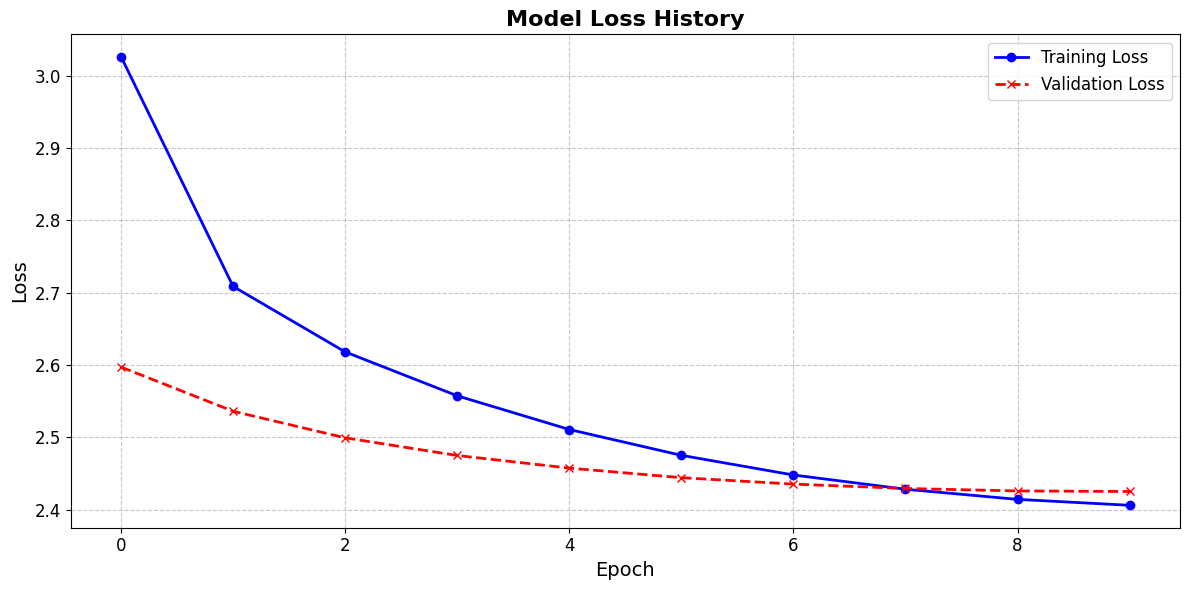

In [13]:
# Extract loss values from the log history
train_loss_values = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss_values = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Plot the loss values
plt.figure(figsize=(12, 6))
plt.plot(train_loss_values, label='Training Loss', marker='o', linestyle='-', color='b', linewidth=2, markersize=6)
plt.plot(eval_loss_values, label='Validation Loss', marker='x', linestyle='--', color='r', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Model Loss History', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [17]:
# Generate text
input_text = "dont know what to say"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

# Generate sequences
model = model.to("cpu")
output = model.generate(input_ids, max_length=50, num_return_sequences=1, 
                        attention_mask=tokenizer(input_text, return_tensors="pt").attention_mask, do_sample=True,
                        no_repeat_ngram_size=2, top_k=50, top_p=0.95, temperature=0.7, early_stopping=True, num_beams=2)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True,)

# Print generated text until the first period
print("Input Text       :", input_text)
print("Generated Text   :", generated_text.rsplit('.', 1)[0] + '.')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Input Text       : dont know what to say
Generated Text   : dont know what to say about this. Ive seen some of the posts on this group, but I dont think it is a good idea to post this here.
